### Republic Of Ireland Milk Sales

Milk Sales (Dairy) for Human Consumption (Million Litres) by Month and Type of Milk
- Data retrived from https://data.gov.ie/dataset/milk-sales-dairy-for-human-consumption-million-litres-by-month-and-type-of-milk
- Landing page http://www.cso.ie/px/pxeirestat/Statire/SelectVarVal/Define.asp?maintable=AKM02&PLanguage=0

In [139]:
#Imports and Setup
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display


import warnings; warnings.simplefilter('ignore')

%matplotlib inline


In [2]:
print(pd.__version__)
print(np.__version__)

0.19.2
1.12.1


In [3]:
#Read cvs file into a data frame
dfmilk= pd.read_csv("AKM02.csv")

In [167]:
dfmilk.tail()

,Type,Date,value
Date,,,
2017-08-01,All Milk,2017-08-01,45.2
2017-08-01,Whole Milk,2017-08-01,27.4
2017-08-01,Skimmed and Semi-skimmed milk,2017-08-01,17.8
2017-08-01,Skimmed Milk,2017-08-01,1.7
2017-08-01,Semi-skimmed milk,2017-08-01,16.1


In [164]:
dfmilk.shape

(2260, 3)

In [5]:
# Remove the index column created in the export to csv from R
del dfmilk['Unnamed: 0']
# Rename columns
dfmilk.rename(columns={'Type.of.Milk': 'Type', 'Month': 'Date' }, inplace=True)
# Remove M character from Data column
dfmilk['Date']  = dfmilk['Date'].str.replace('M','')

In [6]:
dfmilk.tail(2)

,Type,Date,value
2258,Skimmed Milk,201708,1.7
2259,Semi-skimmed milk,201708,16.1


In [7]:
# Change column to date data type
dfmilk['Date'] = pd.to_datetime(dfmilk['Date'], format='%Y%m')
# Set date column as the data frame index
dfmilk.index = dfmilk.Date

In [8]:
dfmilk.tail(2)

,Type,Date,value
Date,,,
2017-08-01,Skimmed Milk,2017-08-01,1.7
2017-08-01,Semi-skimmed milk,2017-08-01,16.1


TypeError: 'str' object is not callable

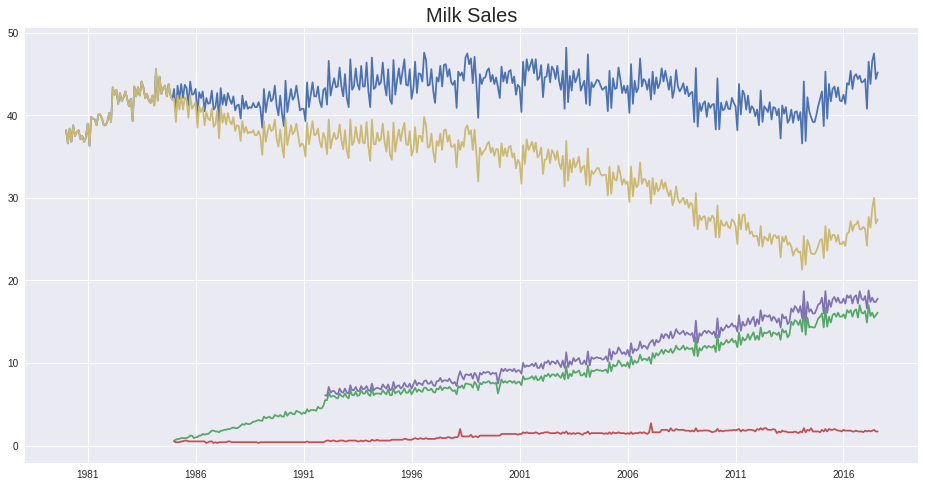

In [193]:
# Plot a graph with a line for each milk type
plt.figure(figsize=(16, 8))
for key, grp in dfmilk.groupby('Type'):
    plt.plot(grp['value'], label=key)
plt.title("Milk Sales", fontsize = 20) 
plt.xlabel("Year")    
plt.ylabel("Litres (Millions)")    
plt.legend(loc='best')     
plt.show()

- For the most part as Skimmed and Semi Skimmed milk sales as increased Whole milk sales have decreased.
- We can test the significane of this relationship.

In [10]:
# Create a pivot table to work with
milkpvt = dfmilk.pivot(index="Date", columns="Type", values="value")

# Reduce column names to one word for ease of use
milkpvt.rename(columns={"All Milk": 'All',
                        "Semi-skimmed milk": 'Semi',
                        "Skimmed Milk": 'Skimmed',
                        "Skimmed and Semi-skimmed milk": 'SkimmedandSemi',
                        "Whole Milk": 'Whole'                        
                       }, inplace=True)

The "Skimmed and Semi-skimmed milk" column are null before 1992 but we can populate some values for that column by summing the "Skimmed Milk" and "Semi-skimmed milk" columns.

In [11]:
# Update SkimmedandSemi column where it is null
milkpvt.loc[milkpvt['SkimmedandSemi'].isnull(), 'SkimmedandSemi'] = milkpvt['Skimmed'] + milkpvt['Semi']

In [12]:
# Remove other columns besides "Whole milk" and "Skimmed and semiskimmed"
del milkpvt['All']
del milkpvt['Semi']
del milkpvt['Skimmed']

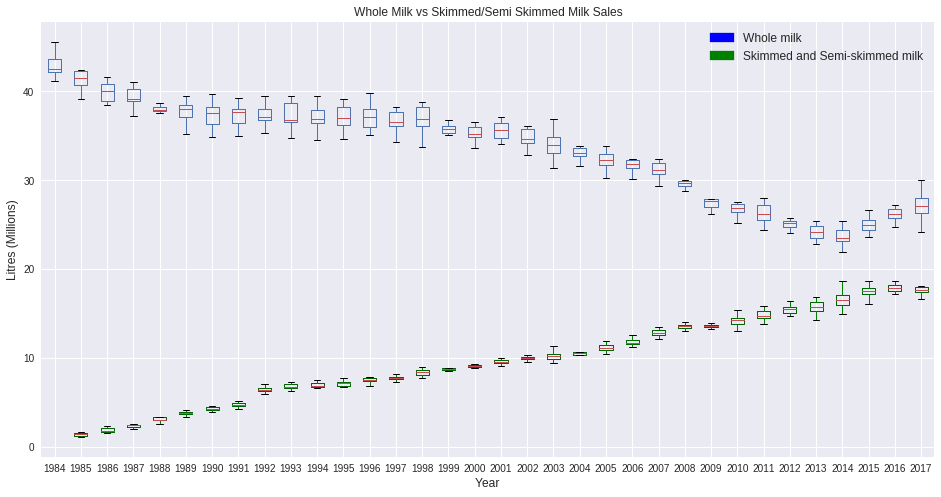

In [309]:
import matplotlib.patches as mpatches
import matplotlib.dates as dates

fig, ax = plt.subplots(figsize=(16,8))

ax.set_title('Whole Milk vs Skimmed/Semi Skimmed Milk Sales')
ax.set_xlabel('Year', fontsize='large'), ax.set_ylabel('Litres (Millions)', fontsize='large')
blue_patch = mpatches.Patch(color='blue', label='Whole milk')
green_patch = mpatches.Patch(color='green', label='Skimmed and Semi-skimmed milk')
plt.legend(handles=[blue_patch,green_patch],  fontsize='large')


milkpvt['1984':].set_index([milkpvt['1984':].index,milkpvt['1984':].index.year]).Whole.unstack().plot.box(ax = ax)
greencolor = dict(boxes='DarkGreen',whiskers='Green')
milkpvt['1984':].set_index([milkpvt['1984':].index,milkpvt['1984':].index.year]).SkimmedandSemi.unstack().plot.box(ax = ax, color=greencolor)



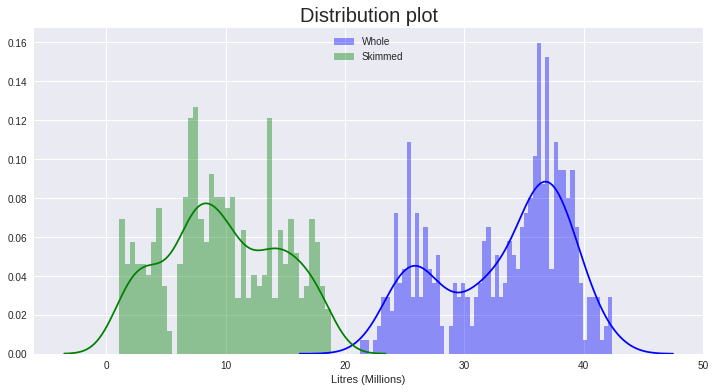

In [29]:
sns.set(rc={"figure.figsize": (12, 6)})
sns.distplot(milkpvt['1985':].Whole,bins=60,color='blue', label='Whole');
sns.distplot(milkpvt['1985':].SkimmedandSemi,bins=40,color='green', label='Skimmed');
plt.title('Distribution plot' , fontsize = 20)
plt.xlabel("Litres (Millions)")
plt.legend(loc=9);
#plt.scatter(milkpvt);
#sns.kdeplot(milkpvt, cmap='cool_d');

In [14]:
plt.clf

<function matplotlib.pyplot.clf>

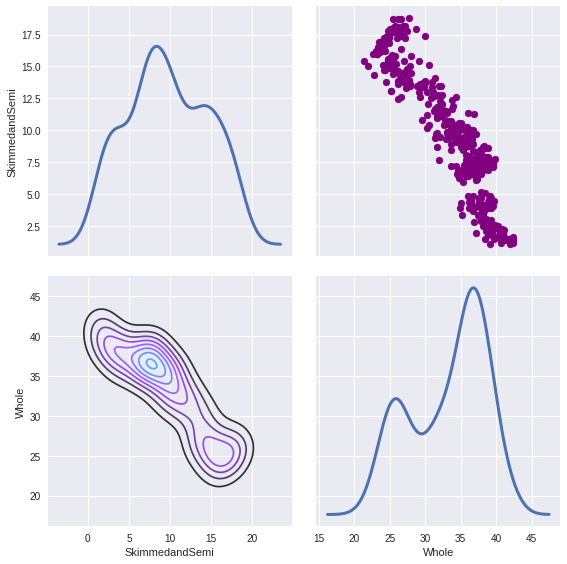

In [143]:
#We can get more contron on the plots by using pair grid
returns_fig=sns.PairGrid(milkpvt['1985':], size=4)
#Map_upper us used to plot graphs in upper grid
returns_fig.map_upper(plt.scatter,color='purple')
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
returns_fig.map_diag(sns.kdeplot, lw=3, legend=False)

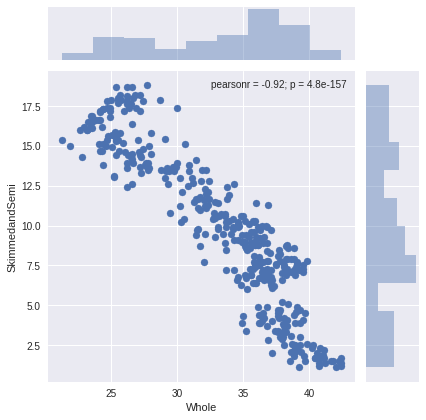

In [16]:
sns.jointplot(milkpvt.Whole,milkpvt.SkimmedandSemi)

In [ ]:
sns.jointplot?

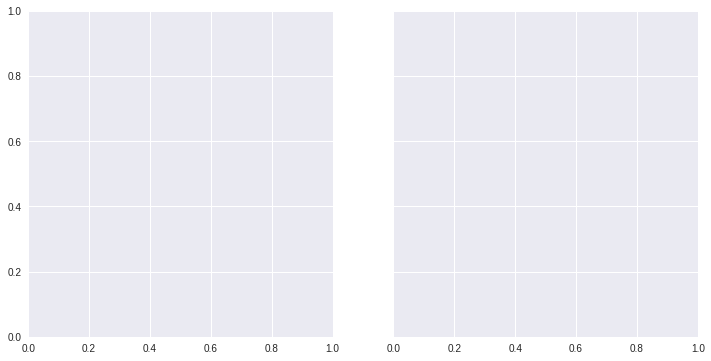

In [17]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
sns.jointplot(milkpvt.Whole,milkpvt.SkimmedandSemi)


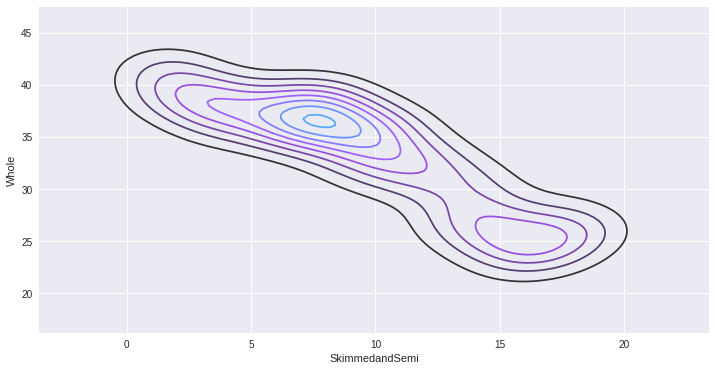

In [28]:
sns.kdeplot(milkpvt['1985':].SkimmedandSemi, milkpvt['1985':].Whole, cmap='cool_d' )